# Titanic Dataset Analysis

This notebook analyzes the Titanic dataset to understand survival patterns among passengers.

## Setup and Data Loading

In [9]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Set up plotting parameters
figsize_with_subplots = (10, 10)

In [12]:
# Load and display the prediction results
df_results = pd.read_csv('./titanic/.results-rf.csv')
print("\nSurvival Predictions:")
print(df_results['Survived'].value_counts())


Survival Predictions:
Survived
0    276
1    142
Name: count, dtype: int64


## Data Overview and Initial Analysis

In [ ]:
# Display basic information about the dataset
print("Training Data Info:")
df_train.info()

print("\nDescriptive Statistics:")
df_train.describe()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB

Descriptive Statistics:


,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.339713
std,120.810458,0.474179
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


## Feature Engineering and Data Cleaning

In [ ]:
def clean_data(df, drop_passenger_id=True):
    # Extract titles from names (simplified)
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # Group titles into fewer categories
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme'], 'Other')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)

    # Convert Sex to numeric
    df['Sex_Val'] = df['Sex'].map({'female': 0, 'male': 1})

    # Handle Embarked missing values and convert to numeric
    df['Embarked'] = df['Embarked'].fillna('S')  # Fill with most common value
    df['Embarked_Val'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

	# Create dummy variables for Embarked
    df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked_Val')], axis=1)

    # Handle Age missing values using more features
    df['AgeFill'] = df['Age']
    df['AgeFill'] = df['AgeFill'].fillna(df.groupby(['Sex_Val', 'Pclass'])['Age'].transform('median'))
    df['AgeFill'] = df['AgeFill'].fillna(df['Age'].median())  # If still missing, use overall median

    # Create basic FamilySize feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Handle Fare missing values
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('median'))

    # Drop unnecessary columns
    columns_to_drop = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'SibSp', 'Parch']
    if drop_passenger_id:
        columns_to_drop.append('PassengerId')

    df = df.drop(columns_to_drop, axis=1)

    return df

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\milively\AppData\Local\Temp\ipykernel_25828\812244334.py:3: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


## Data Visualization

KeyError: 'Pclass'

KeyError: 'Pclass'

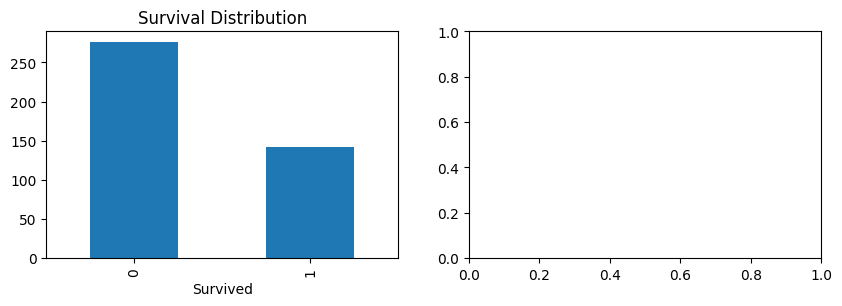

In [ ]:
# Create key visualizations
fig = plt.figure(figsize=figsize_with_subplots)
fig_dims = (3, 2)

# Survival distribution
plt.subplot2grid(fig_dims, (0, 0))
df_train['Survived'].value_counts().plot(kind='bar', title='Survival Distribution')

# Class distribution
plt.subplot2grid(fig_dims, (0, 1))
df_train['Pclass'].value_counts().plot(kind='bar', title='Passenger Class Distribution')

# Age distribution
plt.subplot2grid(fig_dims, (1, 0))
df_train['Age'].hist(bins=30)
plt.title('Age Distribution')

# Fare distribution
plt.subplot2grid(fig_dims, (1, 1))
df_train['Fare'].hist(bins=50)
plt.title('Fare Distribution')

plt.tight_layout()

## Advanced Visualizations

In [ ]:
# Create a figure for our advanced visualizations
plt.figure(figsize=(15, 6))

# First subplot - Survival Rate by Title
plt.subplot(1, 2, 1)
df_title = df_train.copy()
df_title['Title'] = df_title['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_survival = df_title.groupby('Title')['Survived'].mean().sort_values(ascending=False)
title_survival.plot(kind='bar')
plt.title('Survival Rate by Title')
plt.xlabel('Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)

# Second subplot - Survival Rate by Class and Sex
plt.subplot(1, 2, 2)
class_sex_survival = df_train.pivot_table(
    index='Pclass',
    columns='Sex',
    values='Survived',
    aggfunc='mean'
)
class_sex_survival.plot(kind='bar', width=0.8)
plt.title('Survival Rate by Class and Sex')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.legend(title='Sex')

plt.tight_layout()
plt.show()

## Model Training and Evaluation

In [ ]:
# Prepare the data
df_train_clean = clean_data(df_train)
df_test_clean = clean_data(df_test, drop_passenger_id=False)

# Split features and target
X_train = df_train_clean.drop('Survived', axis=1).values
y_train = df_train_clean['Survived'].values

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
predictions = rf_model.predict(df_test_clean.drop(['PassengerId'], axis=1).values)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': df_test_clean['PassengerId'],
    'Survived': predictions
})
submission.to_csv('titanic_predictions.csv', index=False)